In [1]:
%load_ext autoreload
%autoreload 2
from causalnet import metrics, data_processing, model, train
import numpy as np
import pandas as pd
import json
import shutil
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
os.chdir("..")
np.random.seed(42)

<a id="1"></a>
### 1. Background

`causalNet` trains the DragonNet model in two stages. The first uses the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, while the second uses the [sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) optimizer. 
This notebook will show you how you can run those 2 stages separately, giving you more direct control over the stages if you wish to make changes to it. 
You can also run both the stages in one go as shown in the previous tutorial notebook.

As shown before in the embeddings notebook, you can either pass pretrained embedding models, or you can let the function train one from scratch.

In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

#Function to fetch the data
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]



df = load_mtpl2(n_samples=300000)
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2209567.0,0.0,0.52,C,11.0,3.0,45.0,50.0,B13,Diesel,280.0,R24,0.0
2209568.0,0.0,1.00,A,8.0,4.0,45.0,50.0,B6,Diesel,30.0,R24,0.0
2209570.0,0.0,0.63,B,6.0,3.0,29.0,76.0,B2,Regular,91.0,R24,0.0


In [3]:
#Categorical Variable definition
categorical_variables = df.select_dtypes(include=['object','category']).columns.tolist()

#Continuous variable definition
continuous_variables = df.select_dtypes(include=['number']).columns.tolist()
##Removing our target variable
continuous_variables.remove('ClaimAmount')

#Treatment variable definition
treatment=["treatment"]
df["treatment"] = np.random.choice([0, 1], size=(len(df),), p=[2/3, 1/3])

#Weight variable definition
weight=["weight"]
df["weight"] = np.random.uniform(low=0.9, high=1.1, size=len(df))

#Target variable definition
target = ['ClaimAmount']


###Calculating optimal max value for the target variable
percent_clip = 0.7
npTarget = df.ClaimAmount.values
filtered = npTarget[npTarget>0.1]
target_clip_val = np.quantile(filtered,percent_clip)
total, gt_percentile = len(npTarget), len(npTarget[npTarget>target_clip_val])
print("If we clip `target` values above the {}th percentile, we'd alter {:.2}% of our data.\nThis is a clip value of {:.4}".format(int(percent_clip*100),100*gt_percentile/total, target_clip_val))


If we clip `target` values above the 70th percentile, we'd alter 1.3% of our data.
This is a clip value of 1.172e+03


In [4]:
causal_net_data = data_processing.preprocessing(data = df, 
                      categorical_variables = categorical_variables, 
                      continuous_variables = continuous_variables, 
                      target_variable = target, 
                      weight_variable = weight,  
                      treatment_variable = treatment, 
                      scale_y = True, # scaling target variable between 0 & 1
                      weight_target = False, #Default. Let's not weight our response.
                      train_split = .8, #Default
                      random_state = 11,
                      y_clip=target_clip_val) #Pass the clipping threshold we determined already 

Setting max value of target variable at 1172.00

Normalizing your y, please hold.



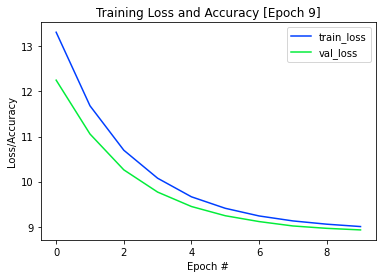

INFO:tensorflow:Assets written to: embed_checkpoint\adam_checkpoints\model.10-8.93\assets


INFO:tensorflow:Assets written to: embed_checkpoint\adam_checkpoints\model.10-8.93\assets


Stage 1 has run for  191.5805003643036


In [5]:
embed_model = 'embed_final/'
checkpoint_path = 'embed_checkpoint/'
tf.random.set_seed(101)

causal_net = train.dragonnet_first_stage(   
                          causal_net_data      = causal_net_data, 
                          checkpoint_path   = checkpoint_path,
                          embeddings_path        = embed_model,
                          rd_one_batch     = 128,
                          rd_one_epoch     = 10,
                          verbose          = 1)

From here, if you're running both training parts back to back, you won't need to reload a model. However, you can also load a model from the checkpoint location to continue the training stage 2. If you want to load a model, you'll need to import the custom objects the `causalNet` uses in the modeling process.

In [7]:
import glob
custom_objects = metrics.custom_objects()

list_of_folders = glob.glob(checkpoint_path+'/adam_checkpoints/*')
latest_file = max(list_of_folders, key=os.path.getctime)
print('Loading {} from checkpoint.'.format(latest_file))
causal_net = load_model(latest_file, custom_objects=custom_objects)

Loading embed_checkpoint//adam_checkpoints\model.10-8.93 from checkpoint.


The stage two model requires the current model, the data object, and the location of the embedding model (if using) as inputs. The results are dictionaries containing the test and train results, along with the final trained model, which may be saved as needed, but is also checkpointed in the designated location.

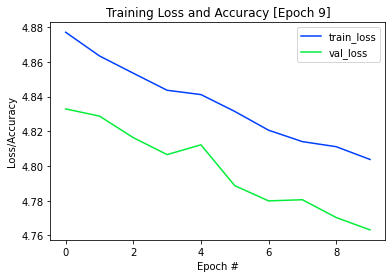

INFO:tensorflow:Assets written to: embed_checkpoint\sgd_checkpoints\model.10-4.76\assets


INFO:tensorflow:Assets written to: embed_checkpoint\sgd_checkpoints\model.10-4.76\assets


***************************** Stage 2 has run for  262.51304507255554
average propensity for treated: 0.3328000009059906 and untreated: 0.33286237716674805
average propensity for treated: 0.33287546038627625 and untreated: 0.33283481001853943


In [10]:
test_outputs, train_outputs, dragonnet = train.dragonnet_second_stage(
                                                      dragonnet_first_stage_model        = causal_net,
                                                      causal_net_data      = causal_net_data, 
                                                      checkpoint_path   = checkpoint_path,
#                                                       embed_loc        = embed_model,
#                                                       dragon           = 'dragonnet',
                                                      rd_two_batch     = 64,
                                                      rd_two_epoch     = 10,
                                                      verbose          = 1)

* Once the training is done, the average propensity (aka prediction of target variable) are printed for the test & training data respectively as shown above

In [15]:
#Convert the final results into pandas dataFrame for further analysis
output_frame=train.unpack(test_outputs, causal_net_data)
output_frame

,q_t0,q_t1,g,t,weight,Area,VehBrand,VehGas,Region,y,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
0,38.432422,39.242215,0.332985,1,0.993812,C,B1,Regular,R82,0.000000,0.0,0.50,7.0,6.0,53.0,50.0,276.0
1,57.922232,52.241117,0.335028,0,0.986525,C,B1,Regular,R53,0.000000,0.0,0.16,7.0,4.0,22.0,85.0,165.0
2,32.854456,34.325603,0.334514,0,1.083502,B,B2,Diesel,R24,0.000000,0.0,1.00,7.0,12.0,50.0,50.0,91.0
3,38.609750,39.293986,0.332846,1,0.999302,D,B6,Diesel,R53,0.000000,0.0,0.75,8.0,5.0,53.0,50.0,644.0
4,38.380065,39.180329,0.332975,1,0.995826,C,B1,Regular,R25,1176.912502,1.0,1.00,7.0,14.0,57.0,50.0,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,33.377103,35.179624,0.335228,1,1.038246,A,B1,Regular,R24,0.000000,0.0,1.00,5.0,17.0,77.0,50.0,29.0
59996,61.593614,53.539831,0.333444,1,1.080838,E,B2,Diesel,R11,0.000000,0.0,0.06,6.0,0.0,58.0,50.0,6308.0
59997,45.034877,42.720552,0.333526,0,1.068394,D,B6,Diesel,R93,0.000000,0.0,0.50,8.0,9.0,71.0,66.0,1326.0
59998,40.941004,42.140605,0.333427,0,0.910187,C,B13,Diesel,R91,0.000000,0.0,1.00,8.0,3.0,61.0,50.0,189.0


In [16]:
output_frame.to_csv('data/causalNet_results.csv')